Nice color picker to generate color schemes: https://coolors.co

In [778]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display,SVG
from matplotlib.ticker import MaxNLocator
from scipy.stats import entropy
import glob
import MESS
import numpy as np
import pandas as pd
import seaborn as sns
import collections

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

analysis_dir = "/home/iovercast/Continuosity/MESS/analysis/figure2-sims/generations_100/"

sp_dict = {"no":0, "lo":0.00005, "hi":0.0001}
models = ["neutral", "competition", "filtering"]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


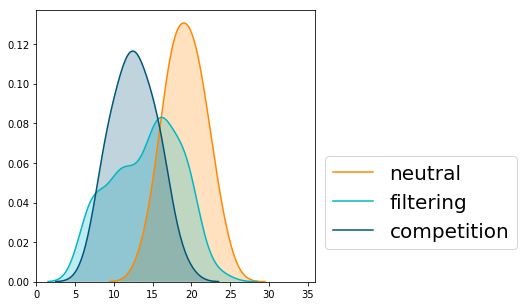

In [783]:
def plot_abundance(ax='', figsize=(5, 5), speciation_prob="no"):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    for m in models:
        simdir = analysis_dir + "{}_MESS/".format(m)

        logs = glob.glob("{}/{}-*/*megalog.txt".format(simdir, speciation_prob))

        log_dat = [pd.read_csv(x)["abundance"].sort_values(ascending=False).values for x in logs]

        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
#        mask = (log_df.notna().sum() >= 15) & (log_df.notna().sum() <= 16)
        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 21)
        log_df = log_df.loc[:, mask]

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, np.log(means), c=MESS.plotting.model_colors[m])
        ax.plot(xs, np.log(means + stds), c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), color=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                        color=MESS.plotting.model_colors[m], alpha=0.25)

def plot_pi(ax='', figsize=(5, 5), speciation_prob="no"):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    for m in models:
        simdir = analysis_dir + "{}_MESS/".format(m)

        logs = glob.glob("{}/{}-*/*megalog.txt".format(simdir, speciation_prob))

        log_dat = [pd.read_csv(x)["pi_local"].sort_values(ascending=False).values for x in logs]

        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
#        mask = (log_df.notna().sum() >= 15) & (log_df.notna().sum() <= 16)
        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 21)
        log_df = log_df.loc[:, mask]

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, color=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds,
                        color=MESS.plotting.model_colors[m], alpha=0.25)


def plot_richness(ax='', figsize=(5, 5), simfile=analysis_dir + "SIMOUT.txt",\
                     speciation_prob="no", xlim=(0,36), legend=False):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)

    labels, sim_df = MESS.plotting._filter_sims(simfile,\
                            feature_set=["S", "speciation_prob"],\
                            normalize_hills=False)

    mask = (sim_df["S"] > 5) & (sim_df["speciation_prob"] == sp_dict[speciation_prob])
    sim_df = sim_df[mask]
    labels = labels[mask]

    neut_df = sim_df[labels.values == "neutral"]
    filt_df = sim_df[labels.values == "filtering"]
    comp_df = sim_df[labels.values == "competition"]

    bw_method=1.5
    ax = sns.kdeplot(neut_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["neutral"],
                    label="neutral", bw=bw_method, kernel=k, legend=legend)
    ax.set_xlim(xlim)
    ax = sns.kdeplot(filt_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["filtering"],
                    label="filtering", bw=bw_method, kernel=k, legend=legend)
    ax.set_xlim(xlim)
    ax = sns.kdeplot(comp_df["S"], ax=ax, shade=True, color=MESS.plotting.model_colors["competition"],
                    label="competition", bw=bw_method, kernel=k, legend=legend)
    ax.set_xlim(xlim)

    ## If you have a legend, increase the font size
    try:
#        plt.legend(fontsize='20', loc='upper left')
        plt.setp(ax.get_legend().get_texts(), fontsize='15') 
    except:
        pass
#plot_abundance()
#plot_pi(speciation_prob="hi")
plot_richness(speciation_prob="lo", legend=False)
plt.legend(bbox_to_anchor=(1, 0.5), fontsize=20)

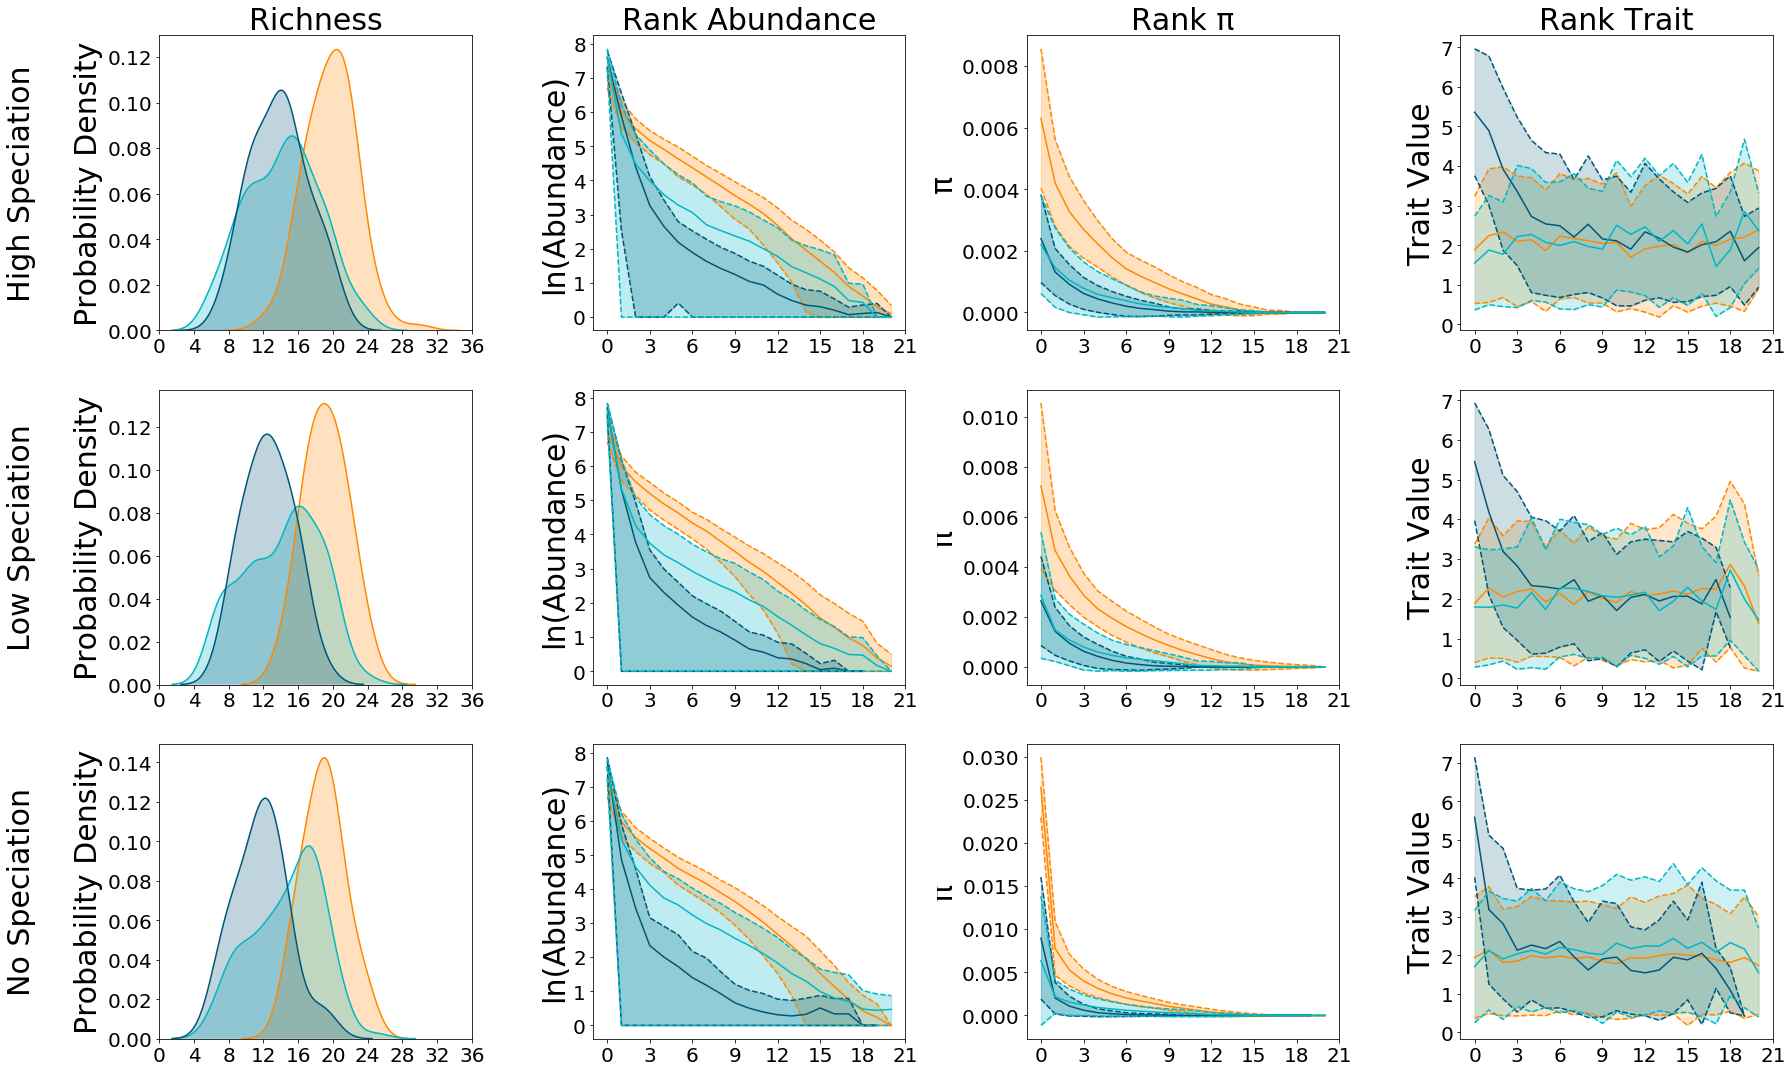

In [784]:
funcs = {"Richness":plot_richness,
         "Rank Abundance":plot_abundance,
         u"Rank π":plot_pi,
         "Rank Trait":plot_traits}
sp_title_dict = {"no":"No", "lo":"Low", "hi":"High"}

fig, axs = plt.subplots(3, 4, figsize=(25, 15))
for i, sp in enumerate(["hi", "lo", "no"]):
    for j, f in enumerate(["Richness", "Rank Abundance", u"Rank π", "Rank Trait"]):
        #if i == 0 and j == 0:
        #        funcs[f](ax=axs[i][j], speciation_prob=sp, legend=True)
        funcs[f](ax=axs[i][j], speciation_prob=sp)

        ## Labeling and cleaning up the plots
        if i % 4 == 0:
            axs[i][j].set_title(f, fontsize=30)
        if j % 4 == 0:
            axs[i][j].set_ylabel("{} Speciation\n\nProbability Density".format(sp_title_dict[sp]), fontsize=30)
        if j % 4 == 1:
            axs[i][j].set_ylabel("ln(Abundance)", fontsize=30)
        if j % 4 == 2:
            axs[i][j].set_ylabel(u"π", fontsize=30)
        if j % 4 == 3:
            axs[i][j].set_ylabel("Trait Value", fontsize=30)
        ## Cast xtick labelsto int
        axs[i][j].xaxis.set_major_locator(MaxNLocator(integer=True))
        
## Make axis ticklabels easier to read
axs = axs.flatten()
_ = [plt.setp(ax.get_xticklabels(), fontsize=20) for ax in axs.flatten()]
_ = [plt.setp(ax.get_yticklabels(), fontsize=20) for ax in axs.flatten()]

plt.tight_layout()

/home/iovercast/Continuosity/MESS/analysis/figure2-sims/generations_100/neutral_MESS/no-figure2-246532944/island1-0.7548-megalog.txt


,name,trait,abundance,Ne_local,Ne_meta,tdiv,growth_rate,migration_rate,segsites_tot,pi_tot,segsites_local,segsites_meta,pi_local,pi_meta,dxy,da,TajimaD
0,t22,-4.190584,221,2.928640e+04,72406,554174,0,1.737549e-08,21,0.011717,4,9,0.001404,0.004016,0.019825,0.017115,-1.535979
1,t55,-2.779811,108,1.157970e+04,20376,100784,0,1.285293e-08,4,0.002188,1,2,0.000351,0.000702,0.003684,0.003158,-1.024317
2,t43,-5.740272,4,8.681831e+03,4380,85305,0,2.700500e-09,3,0.001690,2,0,0.001287,0.000000,0.002632,0.001988,0.230450
3,t87,-0.731105,60,2.501253e+04,32317,252474,0,8.392697e-09,10,0.006602,5,2,0.004094,0.001559,0.010000,0.007173,1.420792
4,t41,-8.011705,4,1.494827e+04,15404,133038,0,1.005688e-08,7,0.004146,3,1,0.001949,0.000351,0.006842,0.005692,0.294693
5,t66,-1.300461,14,7.305268e+03,23600,43185,0,1.901876e-08,1,0.000776,0,1,0.000000,0.000936,0.001053,0.000585,0.000000
6,t61,-4.378476,795,2.698497e+06,161169,625000,0,4.340195e-10,99,0.029289,62,37,0.026511,0.026199,0.031930,0.005575,-1.357777
7,t3,-0.902383,4,3.200000e+03,5572,6353,0,4.918936e-08,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
8,t1,2.735488,4,3.200000e+03,9133,2343,0,0.000000e+00,2,0.000508,0,2,0.000000,0.000975,0.000526,0.000039,0.000000
9,t72,2.029248,33,1.802083e+04,38371,325762,0,1.277574e-08,15,0.009363,5,8,0.004094,0.006589,0.012982,0.007641,1.420792


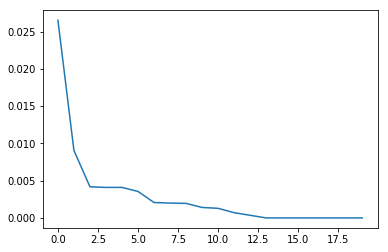

In [223]:
simdir = analysis_dir + "neutral_MESS"
logs = glob.glob("{}/no-*/*megalog*".format(simdir))
print(logs[-1])
df = pd.read_csv(logs[-1])
pis = df["pi_local"]
xs = range(0, len(pis))
ys = sorted(pis, reverse=True)
plt.plot(xs, ys)
df

Removed invariant targets. Retained: ['S']
Nsims
  neutral	240
  filtering	240
  competition	160


array([<matplotlib.axes._subplots.AxesSubplot object at 0x2aab4d0bac90>],
      dtype=object)

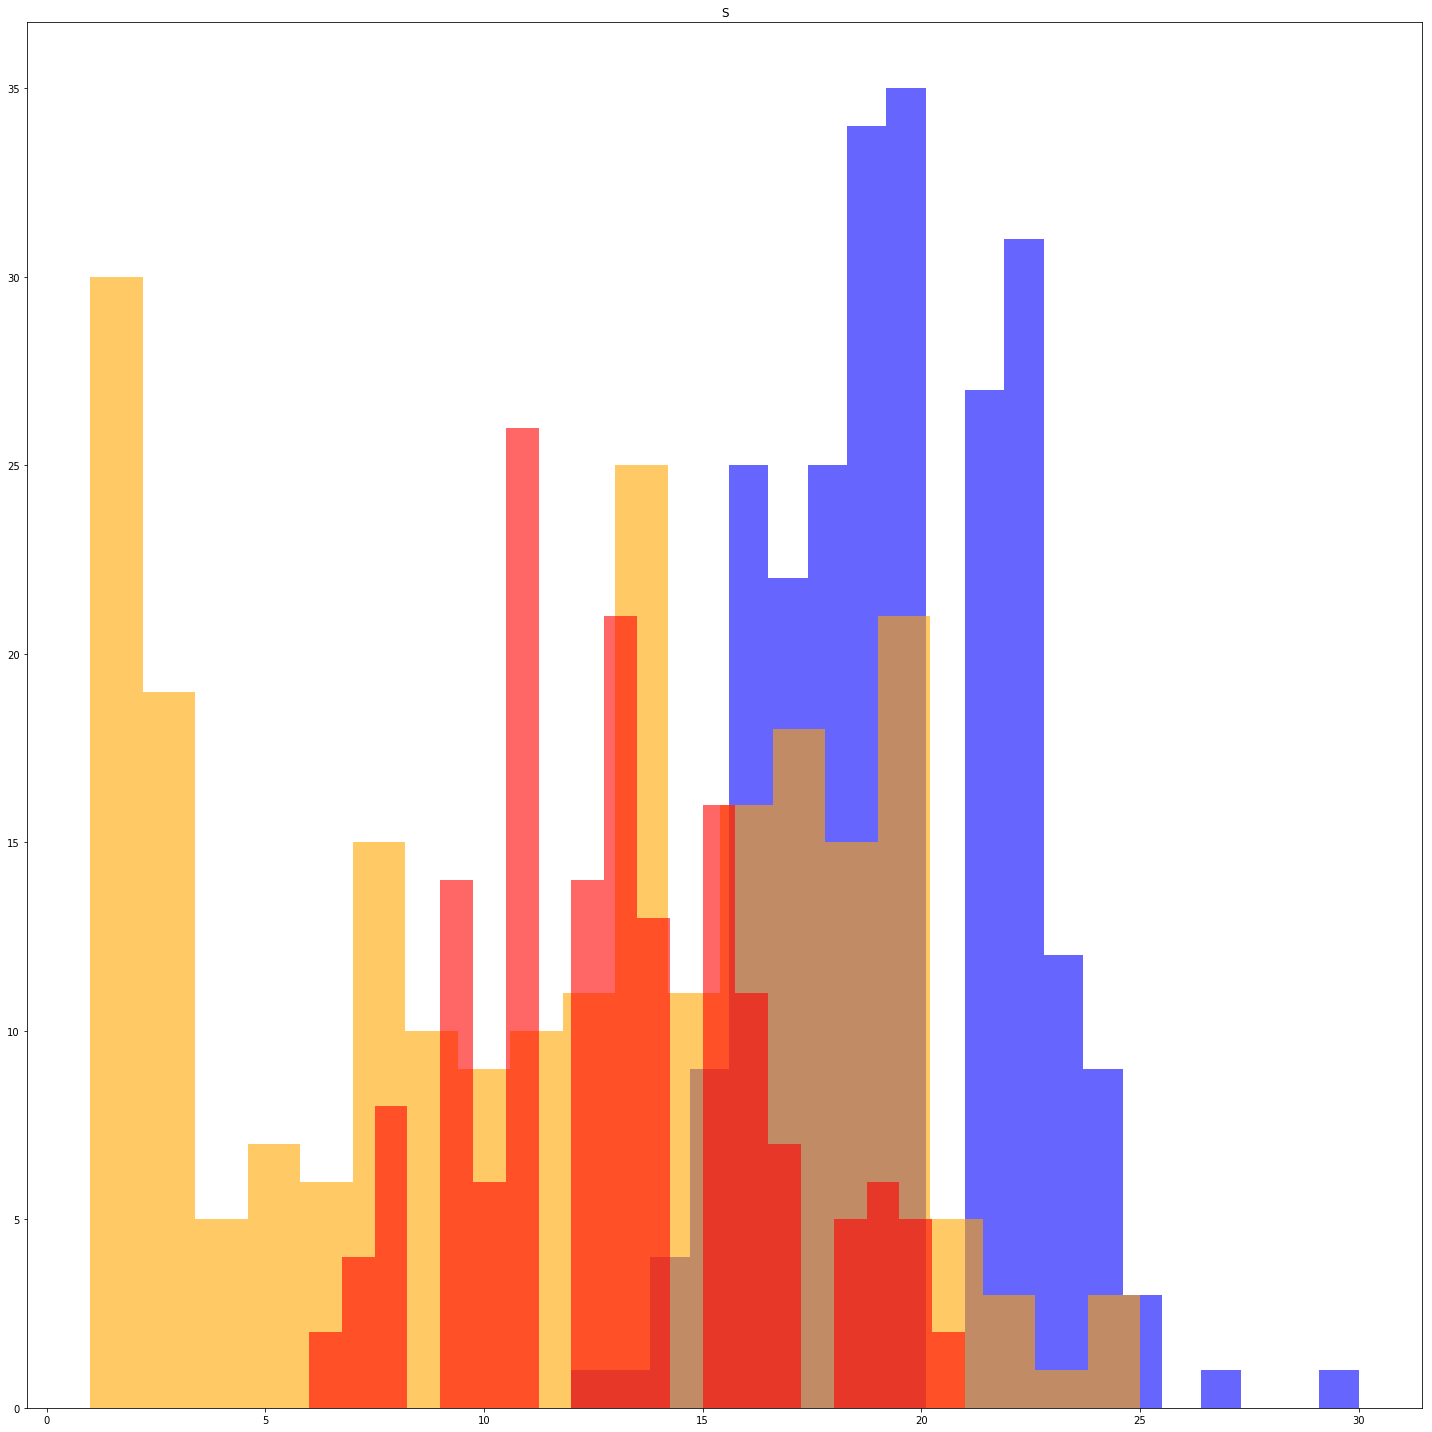

In [441]:
simfile = analysis_dir + "SIMOUT.txt"
#simfile = analysis_dir + "SIMOUT.txt"
sim_df = pd.read_csv(simfile, sep="\t", header=0)
MESS.plotting.plot_simulations_hist(simfile, verbose=True, normalize_hills=False,\
                                        feature_set=["S"])

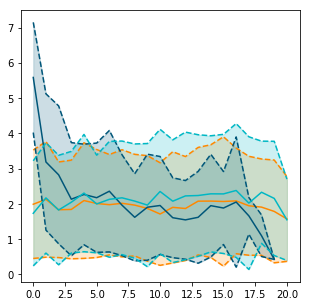

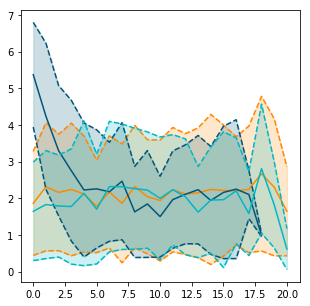

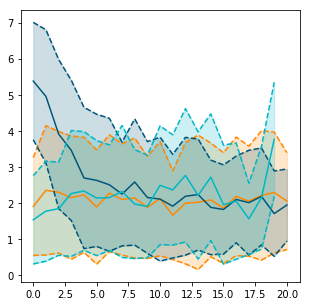

In [743]:
def plot_traits(ax='', speciation_prob='hi', do_abs=True):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for m in models:
        simdir = analysis_dir + "{}_MESS".format(m)

        logs = glob.glob("{}/{}-*/*megalog*".format(simdir, speciation_prob))
        log_dat = [pd.read_csv(x).sort_values(by=["abundance"], ascending=False) for x in logs]
        log_df = pd.concat(map(pd.Series, [x["trait"].values for x in log_dat]), axis=1)
        abunds = pd.concat(map(pd.Series, [x["abundance"].values for x in log_dat]), axis=1)
        #display(log_df)
        mask = (log_df.notna().sum() >= 3) & (log_df.notna().sum() <= 21)
        log_df = log_df.loc[:, mask]
        mask = (abunds.notna().sum() >= 3) & (abunds.notna().sum() <= 21)
        abunds = abunds.loc[:, mask]

        col_means = log_df.mean()
        col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
        if do_abs:
            log_df = pd.DataFrame(np.abs(log_df.values - col_means_vec))
        else:
            log_df = pd.DataFrame(log_df.values - col_means_vec)
        
        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds, alpha=0.2, color=MESS.plotting.model_colors[m])

        ## Plot the average RAD
        #ax.plot(xs, np.log(abunds.apply(np.mean, axis=1)), c=MESS.plotting.model_colors[m])
        #ax.set_title(sp_prob, fontsize=20)
#plot_traits(speciation_prob="no", do_abs=False)
plot_traits(speciation_prob="no", do_abs=True)
plot_traits(speciation_prob="lo", do_abs=True)
plot_traits(speciation_prob="hi", do_abs=True)


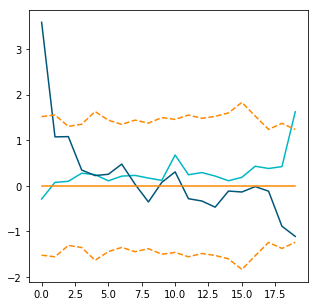

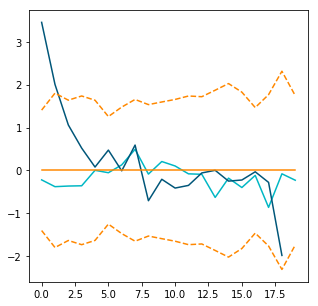

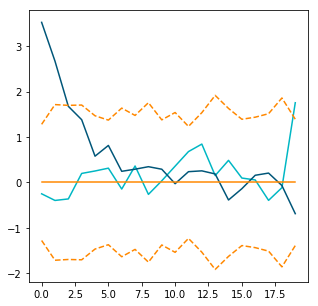

In [708]:
def plot_traits_residuals(ax='', sp_prob='hi'):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    mean_dict = {}
    std_dict = {}
    for m in models:
        simdir = analysis_dir + "{}_MESS".format(m)

        logs = glob.glob("{}/{}-*/*megalog*".format(simdir, sp_prob))
        log_dat = [pd.read_csv(x).sort_values(by=["abundance"], ascending=False) for x in logs]
        log_df = pd.concat(map(pd.Series, [x["trait"].values for x in log_dat]), axis=1)
        abunds = pd.concat(map(pd.Series, [x["abundance"].values for x in log_dat]), axis=1)
        #display(log_df)
        mask = (log_df.notna().sum() >= 5) & (log_df.notna().sum() <= 20)
        log_df = log_df.loc[:, mask]
        mask = (abunds.notna().sum() >= 5) & (abunds.notna().sum() <= 20)
        abunds = abunds.loc[:, mask]

        col_means = log_df.mean()
        col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
        log_df = pd.DataFrame(np.abs(log_df.values - col_means_vec))

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        mean_dict[m] = means[:24]
        std_dict[m] = stds[:24]

    for m in ["filtering", "competition"]:
        xs = range(0, len(mean_dict["neutral"]))
        means = (mean_dict[m] - mean_dict["neutral"])
        stds = (std_dict[m] - std_dict["neutral"])
        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        #ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        #ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        #ax.fill_between(xs, means - stds, means + stds, alpha=0.2, color=MESS.plotting.model_colors[m])
    xs = range(0, 20)
    ax.plot(xs, [0]*len(xs), color=MESS.plotting.model_colors["neutral"])
    ax.plot(xs, 0 + std_dict["neutral"][:20], c=MESS.plotting.model_colors["neutral"], ls='--')
    ax.plot(xs, 0 - std_dict["neutral"][:20], c=MESS.plotting.model_colors["neutral"], ls='--')

plot_traits_residuals(sp_prob="no")
plot_traits_residuals(sp_prob="lo")
plot_traits_residuals(sp_prob="hi")

In [548]:
mn = log_df[0].mean()
print(mn)
np.abs(log_df[0] - mn) * abunds.iloc[:, 0]

8.881784197001253e-17


0        9.821582
1        3.843132
2       13.929468
3        1.058691
4       15.230073
5        8.727323
6        3.868035
7        9.987557
8     9214.772619
9        3.481255
10      26.084566
11     983.799582
12       3.523819
13       6.020068
14       6.710186
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
dtype: float64

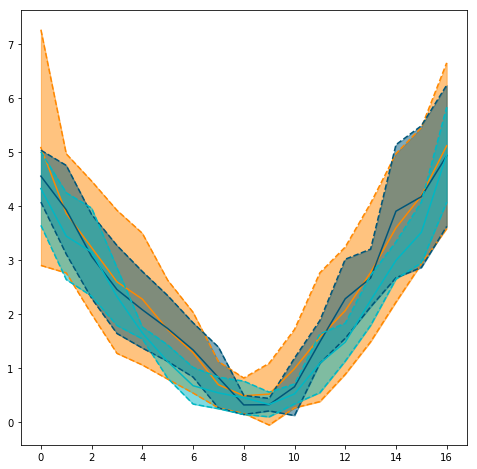

In [621]:
fig, ax = plt.subplots(figsize=(8, 8))
traits = True

for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)

    for sp in ["lo"]:
        logs = glob.glob("{}/{}-*/*megalog.txt".format(simdir, sp))
        log_dat = [pd.read_csv(x)["trait"].sort_values(ascending=False).values for x in logs]
        
        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
        mask = log_df.notna().sum() == 17
        log_df = log_df.loc[:, mask]

        if traits:
            col_means = log_df.mean()
            col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
            log_df = pd.DataFrame(abs(log_df.values - col_means_vec))

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))

        ax.plot(xs, means, c=MESS.plotting.model_colors[m])
        ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.plot(xs, means - stds, c=MESS.plotting.model_colors[m], ls='--')
        ax.fill_between(xs, means - stds, means + stds, color=MESS.plotting.model_colors[m],alpha=0.5)


In [396]:
# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data)

# evaluate on a regular grid
xgrid = np.linspace(-3.5, 3.5, 40)
ygrid = np.linspace(-6, 6, 40)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[-3.5, 3.5, -6, 6],
           cmap='Blues')
cb = plt.colorbar()
cb.set_label("density")

,S
0,21.0
1,11.0
2,19.0
3,14.0
4,13.0
5,9.0
6,9.0
7,20.0
8,12.0
9,11.0


## Trash below here

Figure 2 Dev

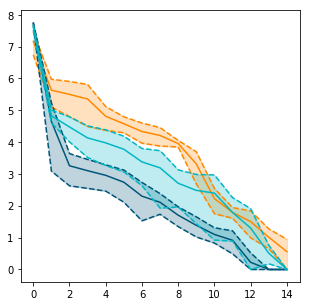

In [619]:
df_dict = {}
fig, ax = plt.subplots(figsize=(5, 5))
traits = False

for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)

    for sp in ["no"]:
        logs = glob.glob("{}/{}-*/*megalog.txt".format(simdir, sp))[:50]

        log_dat = [pd.read_csv(x)["abundance"].sort_values(ascending=False).values for x in logs]
        
        log_df = pd.concat(map(pd.Series, log_dat), axis=1)
        mask = log_df.notna().sum() == 15
        log_df = log_df.loc[:, mask]

        if traits:
            col_means = log_df.mean()
            col_means_vec = col_means.values.reshape((1, col_means.shape[0]))
            log_df = pd.DataFrame(log_df.values - col_means_vec)

        means = log_df.apply(np.mean, axis=1)
        stds = log_df.apply(np.std, axis=1)
        xs = range(0, len(means))
        if True:
            ax.plot(xs, np.log(means), c=MESS.plotting.model_colors[m])
            ax.plot(xs, np.log(means + stds), c=MESS.plotting.model_colors[m], ls='--')
            ax.plot(xs, np.log(np.clip(means - stds, 1, a_max=None)), color=MESS.plotting.model_colors[m], ls='--')
            ax.fill_between(xs, np.log(np.clip(means - stds, 1, a_max=None)), np.log(means + stds),
                            color=MESS.plotting.model_colors[m], alpha=0.25)
        else:
            ax.plot(xs, means, c=MESS.plotting.model_colors[m])
            ax.plot(xs, means + stds, c=MESS.plotting.model_colors[m], ls='--')
            ax.plot(xs, means - stds, color=MESS.plotting.model_colors[m], ls='--')
            ax.fill_between(xs, means - stds, means + stds,
                            color=MESS.plotting.model_colors[m], alpha=0.25)


The RAC version is unparsable.

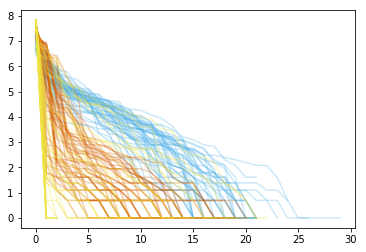

In [562]:
models = ["neutral", "competition", "filtering"]
df_dict = {}
for m in models:
    df_dict[m] = pd.DataFrame()
    simdir = analysis_dir + "{}_MESS/".format(m)
    for sp in ["hi"]:
        dirs = glob.glob("{}/{}-*".format(simdir, sp))[:50]
        for d in dirs:
            try:
                df = pd.read_csv(glob.glob("{}/*megalog*".format(d))[0])
            except:
                pass
            pis = df["abundance"]
            xs = range(0, len(pis))
            ys = np.log(sorted(pis, reverse=True))
            #ys = sorted(pis, reverse=True)
            plt.plot(xs, ys, c=MESS.plotting.model_colors[m], alpha=0.3)
            #plt.xlim(0, 15)